In [141]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

In [142]:
print("hello world")

hello world


In [143]:
import getpass
import os

from dotenv import load_dotenv

load_dotenv()

def set_env(key: str):
  if key not in os.environ:
    os.environ[key]=getpass.getpass(f"{key}:")


In [144]:
set_env("GROQ_API_KEY")
set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="sql-llm-agent-og"

In [145]:
username = "root"
password = "jagan2911"
host = 'localhost'
database = 'jagandb'

In [146]:
from langchain_community.utilities import SQLDatabase
import pymysql

In [147]:
db = SQLDatabase.from_uri(f"mysql+pymysql://{username}:{password}@{host}/{database}",sample_rows_in_table_info = 3)
print(db.dialect)
print(db.get_usable_table_names())

mysql
['employee']


In [284]:
from langchain_community.utilities import SQLDatabase
from typing import Any
from langchain_core.runnables import RunnableWithFallbacks, RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode

In [285]:
QUERY_CHECK_INSTRUCTION = """You are a SQL expert with a strong attention to detail.
Double check the SQL query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""


QUERY_GEN_INSTRUCTION = """You are a SQL expert with exceptional attention to detail. Your task is to analyze user requests, interpret SQL query results, and provide appropriate responses. Follow these instructions:

Identify Key Components: Carefully analyze the user's message to determine:



The user question.
The provided table schemas.
Any SQL query statements.
The query result or error (if applicable).
Handle Missing Queries: If no query result is available to answer the user's question:

Construct a syntactically correct SQL query to address the user question.
Do not perform any DML operations (e.g., INSERT, UPDATE, DELETE, DROP).
Do not create any new tables with your own schema .
Respond only with the SQL query statement.
Example:
SELECT id, name FROM pets;
Handle Query Errors: If a query was executed but resulted in an error:

Respond by repeating the exact error message.
Example:
"Error: Pets table doesn't exist"
Interpret Results: If a query was executed successfully and returned results:

Interpret the results to answer the user's question.
Respond in the format: Answer: <<question answer>>
Example:
"Answer: There are three cats registered as adopted."
Instructions:
Apply these steps to handle user queries effectively. Your primary focus is to ensure correctness, clarity, and precision in your responses.
If you are unable to generate any query, reply that you dont have information to answer that question. Do not hallucinate.
If there are any summaries present refer the previous queries and context provided in the summary for more reference.
IMPORTANT:
Also if there is a result from db_query_tool that is the result on executing the query use that to infer yout result
"""

In [286]:
def create_tool_node_with_fallback(tools:list)-> RunnableWithFallbacks[Any,dict]:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],exception_key="error"
    )
def handle_tool_error(state)->dict:
    error=state.get("error")
    tool_calls=state["messages"][-1].tool_calls
    return {
        "messages":[ToolMessage(
            content=f"Error:{repr(error)}\n Fix your code and try again. ",
            tool_call_id=tc["id"],
        )
         for tc in tool_calls          
        ]
    }   

In [287]:
toolkit= SQLDatabaseToolkit(db=db, llm=ChatGroq(model="llama-3.3-70b-specdec"))
tools= toolkit.get_tools()

In [288]:
toolkit= SQLDatabaseToolkit(db=db, llm=ChatGroq(model="llama-3.3-70b-specdec"))
tools= toolkit.get_tools()
list_tables_tool=next(tool for tool in tools if tool.name=="sql_db_list_tables")    
get_schema_tool=next(tool for tool in tools if tool.name=="sql_db_schema")

print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("employee"))

employee

CREATE TABLE employee (
	`EmployeeID` INTEGER NOT NULL, 
	`EmployeeName` VARCHAR(255) NOT NULL, 
	`DateOfJoining` DATE NOT NULL, 
	`EmployeeType` VARCHAR(255), 
	`PayTier` VARCHAR(255), 
	PRIMARY KEY (`EmployeeID`)
)ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci DEFAULT CHARSET=utf8mb4

/*
3 rows from employee table:
EmployeeID	EmployeeName	DateOfJoining	EmployeeType	PayTier
1	John Doe	2023-01-15	Manager	Tier 1
2	Jane Smith	2022-06-01	Engineer-1	Tier 3
3	Alice Johnson	2021-09-12	Tester	Tier 4
*/


In [289]:
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [290]:
from langchain_core.tools import tool

@tool
def db_query_tool(query:str)->str:
    """Executes an sql query against the database and gets back 
    the result. If query is not correct an error message is returned.

    Args:
        query (str): A valid sql query string

    Returns:
        str: The result of the query if present or an error message
    """
    try:
        result=db.run_no_throw(query)
        if not result:
            return "Error: Query failed to return anything. Try again."
        return result
    except Exception as e:
        return f"Error: {str(e)}. Please check your query again."

In [291]:
print(db_query_tool.invoke("SELECT * FROM employee"))
print(db_query_tool.invoke("SELECT * FROM employeeee"))
print(db_query_tool.invoke("SELECT * FROM employee where PayTier = 100"))

[(1, 'John Doe', datetime.date(2023, 1, 15), 'Manager', 'Tier 1'), (2, 'Jane Smith', datetime.date(2022, 6, 1), 'Engineer-1', 'Tier 3'), (3, 'Alice Johnson', datetime.date(2021, 9, 12), 'Tester', 'Tier 4'), (4, 'Bob Brown', datetime.date(2020, 3, 23), 'Engineer-2', 'Tier 2'), (5, 'Charlie Davis', datetime.date(2023, 7, 8), 'Team Lead', 'Tier 1'), (6, 'Eve Martin', datetime.date(2019, 11, 5), 'Engineer-1', 'Tier 3'), (7, 'Frank White', datetime.date(2022, 2, 17), 'Tester', 'Tier 4'), (8, 'Grace Green', datetime.date(2021, 8, 30), 'Manager', 'Tier 1'), (9, 'Hank Lee', datetime.date(2020, 12, 19), 'Engineer-2', 'Tier 2'), (10, 'Ivy Wilson', datetime.date(2023, 3, 11), 'Team Lead', 'Tier 1'), (11, 'Jack Black', datetime.date(2022, 5, 25), 'Engineer-1', 'Tier 3'), (12, 'Karen Scott', datetime.date(2021, 7, 14), 'Tester', 'Tier 4'), (13, 'Larry Adams', datetime.date(2020, 9, 1), 'Engineer-2', 'Tier 2'), (14, 'Mona Young', datetime.date(2019, 4, 22), 'Manager', 'Tier 1'), (15, 'Nate King', da

In [292]:
query_check_prompt=ChatPromptTemplate.from_messages([("system",QUERY_CHECK_INSTRUCTION),("placeholder","{messages}")])

In [293]:
query_check_prompt.pretty_print()

================================ System Message ================================

You are a SQL expert with a strong attention to detail.
Double check the SQL query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.

============================= Messages Placeholder =============================

{messages}


In [294]:
query_checker=query_check_prompt | ChatGroq(model="llama-3.3-70b-specdec",temperature=0).bind_tools([db_query_tool],tool_choice="required")


In [295]:
query_gen_prompt=ChatPromptTemplate.from_messages([("system",QUERY_GEN_INSTRUCTION),("placeholder","{messages}")])
query_gen_chain=query_gen_prompt | ChatGroq(model="llama-3.3-70b-versatile") 


In [296]:
query_gen_prompt.pretty_print()

================================ System Message ================================

You are a SQL expert with exceptional attention to detail. Your task is to analyze user requests, interpret SQL query results, and provide appropriate responses. Follow these instructions:

Identify Key Components: Carefully analyze the user's message to determine:



The user question.
The provided table schemas.
Any SQL query statements.
The query result or error (if applicable).
Handle Missing Queries: If no query result is available to answer the user's question:

Construct a syntactically correct SQL query to address the user question.
Do not perform any DML operations (e.g., INSERT, UPDATE, DELETE, DROP).
Do not create any new tables with your own schema .
Respond only with the SQL query statement.
Example:
SELECT id, name FROM pets;
Handle Query Errors: If a query was executed but resulted in an error:

Respond by repeating the exact error message.
Example:
"Error: Pets table doesn't exist"
Interpr

In [297]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
config = {"configurable": {"thread_id": "1"}}

In [298]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage,HumanMessage,RemoveMessage
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import START,END,StateGraph, MessagesState

In [299]:
class State(MessagesState):
    summary: str
    pass

In [300]:
from langchain_core.messages import trim_messages

def summarize(state: State):
    if len(state["messages"]) >5:
        summary = state.get("summary", "")
        if summary:
            # A summary already exists
            summary_message = (
                f"""This is summary of the conversation to date: {summary}\n\n
                Please extend the existing conversation summary by:

                1. PRIORITY ELEMENTS (Must Preserve):
                - Complete SQL queries exactly as generated
                - Original natural language requests that led to queries
                - Table schemas and database context
                - Most recent conversation elements

                2. FORMATTING RULES:
                - If total length exceeds 500 words:
                * Prioritize most recent exchanges
                * Maintain all SQL queries in full
                * Condense older context while preserving key details
                * Use bullet points for clarity

                3. CONTENT GUIDELINES:
                - Include only explicitly stated information
                - No assumptions or inferred details
                - Maintain chronological flow
                - Highlight query-context relationships

                4. STRUCTURE:
                - Recent Information (Latest exchanges)
                - SQL Queries (With associated context)
                - Schema Details (As referenced)
                - Earlier Context (Condensed if needed)

                Note: Focus on technical accuracy and query preservation while maintaining a clear, concise narrative flow."""
            )
            
        else:
            summary_message = """Generate a summary of the conversation above, focusing on the process of converting a natural language input into 
            an SQL query. Retain the exact SQL query that was generated without any modifications. 
            Additionally, preserve the context in which the query was created, 
            including the original natural language request and the table schema used. Do not add or 
            assume any information beyond what was explicitly stated in the conversation."""

        # Add prompt to our history
        model=ChatGroq(model="mixtral-8x7b-32768")
        messages = state["messages"][:-1] + [HumanMessage(content=summary_message)]
        response = model.invoke(messages)
        if len(state["messages"])>5:
            delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
        else:
            delete_messages-state["messages"]
        return {"summary": response.content, "messages": delete_messages}
    return state
    
    

In [301]:
list_tables = create_tool_node_with_fallback([list_tables_tool])

get_schema_tool_with_fallback = create_tool_node_with_fallback([get_schema_tool])

execute_query = create_tool_node_with_fallback([db_query_tool])


In [302]:
execute_query

RunnableWithFallbacks(runnable=tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'writer': False, 'store': True, 'previous': False}, tools_by_name={'db_query_tool': StructuredTool(name='db_query_tool', description='Executes an sql query against the database and gets back \n    the result. If query is not correct an error message is returned.\n\n    Args:\n        query (str): A valid sql query string\n\n    Returns:\n        str: The result of the query if present or an error message', args_schema=<class 'langchain_core.utils.pydantic.db_query_tool'>, func=<function db_query_tool at 0x0000025D0A8A3E20>)}, tool_to_state_args={'db_query_tool': {}}, tool_to_store_arg={'db_query_tool': None}, handle_tool_errors=True, messages_key='messages'), fallbacks=[RunnableLambda(handle_tool_error)], exception_key='error')

In [303]:
def first_tool_call(state:State) ->dict[str,list[AIMessage]]:
    tool_call={"name":"sql_db_list_tables",
               "args":{},
               "id":"tool_abcd123"}
    return {"messages":[AIMessage(
        content='',
        tool_calls=[tool_call])]}


In [304]:
def model_check_query(state:State)->dict[str,list[AIMessage]]:
    return {"messages": [query_checker.invoke({"messages": [state["messages"][-1]]})]}



In [305]:
SCHEMA_INSTRUCTION="""The given is the schema of the table/tables we are querying for . 
Remember this is just a schema don't base your final answer on this . Use this to formulate your queries ...Nothing more

{messages}"""

In [306]:
schema_prompt=ChatPromptTemplate.from_messages([("system",SCHEMA_INSTRUCTION),("placeholder","{messages}")])

In [307]:
schema_prompt.pretty_print()

================================ System Message ================================

The given is the schema of the table/tables we are querying for . 
Remember this is just a schema don't base your final answer on this . Use this to formulate your queries ...Nothing more

{messages}

============================= Messages Placeholder =============================

{messages}


In [308]:
def model_get_schema(state:State):
    model_get_schema=schema_prompt|ChatGroq(model="llama-3.3-70b-specdec",temperature=0).bind_tools([get_schema_tool],tool_choice="required")
    return {
        "messages":[model_get_schema.invoke({"messages":state["messages"]})]
    }
def query_gen_node(state:State):
    message=query_gen_chain.invoke(state,config=config)
    return {"messages":[message]}

In [309]:
def should_continue(state:State)-> Literal[END,"correct_query","query_gen"]:
    messages=state["messages"]
    last_message=messages[-1]
    if last_message.content.startswith("Answer:"):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [310]:
prompt = """System
            You are an helpful assistant who understands what the incoming message is about.
            If the message is about generating SQL or SQLite queries, you send the message ‘sql’.Our database maintains tables for an employee HR app.So
            anything related about the employee and getting their details route it to 'sql'.
            If the incoming message is not about SQL queries or doesn't need to generate SQL queries/query, you will send a reply as ‘message’.
            Don't add anything to it just ANSWER in one word
            For example:
            user: what is the capital of germany
            AI ‘message’
            user: ‘How many distinct types of employees are present ’
            AI : ‘sql’
        Also The below in the summary of previous conversations , if the incoming message is related about the summary which used is a SQL
        type query , List the incoming message as an sql query too.
    """
category_deciding_prompt=ChatPromptTemplate.from_messages([("system",prompt),("placeholder","{messages}")])
category_deciding_llm=category_deciding_prompt|ChatGroq(model="llama-3.3-70b-versatile")

In [311]:
category_deciding_prompt.pretty_print()

================================ System Message ================================

System
            You are an helpful assistant who understands what the incoming message is about.
            If the message is about generating SQL or SQLite queries, you send the message ‘sql’.Our database maintains tables for an employee HR app.So
            anything related about the employee and getting their details route it to 'sql'.
            If the incoming message is not about SQL queries or doesn't need to generate SQL queries/query, you will send a reply as ‘message’.
            Don't add anything to it just ANSWER in one word
            For example:
            user: what is the capital of germany
            AI ‘message’
            user: ‘How many distinct types of employees are present ’
            AI : ‘sql’
        Also The below in the summary of previous conversations , if the incoming message is related about the summary which used is a SQL
        type query , List the incomi

In [312]:
def route_to_research(state:State):
    initial_message = state["messages"]

    router = category_deciding_llm.invoke(input={"messages": initial_message} ,config=config)
    #
    if router.content== 'sql':
        return "first_tool_call"
    elif router.content == 'message':
        return "general_chat"

In [ ]:
prompt_general="""Answer the message in the most appropriate and general way to the given message. 
    Maintain a neutal and a formal tone . If anything inappropriate is encountered answer with 'Can't answer this ask something different' """
general_prompt=ChatPromptTemplate.from_messages([("system",prompt_general),("placeholder","{messages}")])
general_task_llm=general_prompt|ChatGroq(model="mixtral-8x7b-32768")

In [314]:
from langchain_core.messages import HumanMessage, SystemMessage


In [315]:
def tool_message(state:State):
    message=state["messages"]
    flag_message="This is the result of the query from the database :" + (message[-1].content)
    messages=[SystemMessage(
        content=flag_message
    )]
    return {"messages": messages}

In [316]:
def message_general(state:State):
    messages=state["messages"]
    answer=general_task_llm.invoke({"messages":messages},config=config)
    return {"messages": [answer]}
    
    

In [317]:
builder=StateGraph(State)
builder.add_node("summarize", summarize)
builder.add_node("general_chat", message_general)
builder.add_node("first_tool_call",first_tool_call)
builder.add_node("list_tables",list_tables)
builder.add_node("get_schema_tool",get_schema_tool_with_fallback)
builder.add_node("model_get_schema",model_get_schema)
builder.add_node("query_gen",query_gen_node)
builder.add_node("correct_query",model_check_query)
builder.add_node("tool_message",tool_message)
builder.add_node("execute_query",execute_query)


In [318]:
builder.add_edge(START, "summarize")
builder.add_conditional_edges("summarize",route_to_research,{
    "first_tool_call":"first_tool_call",
    "general_chat":"general_chat"
})
builder.add_edge("first_tool_call", "list_tables")
builder.add_edge("list_tables", "model_get_schema")
builder.add_edge("model_get_schema", "get_schema_tool")
builder.add_edge("get_schema_tool", "query_gen")
builder.add_conditional_edges("query_gen", should_continue)
builder.add_edge("correct_query", "execute_query")
builder.add_edge("execute_query", "tool_message")
builder.add_edge("tool_message", "query_gen")
builder.add_edge("general_chat",END)


In [319]:
graph=builder.compile(checkpointer=memory)
#react_graph_memory = builder.compile(checkpointer=memory)

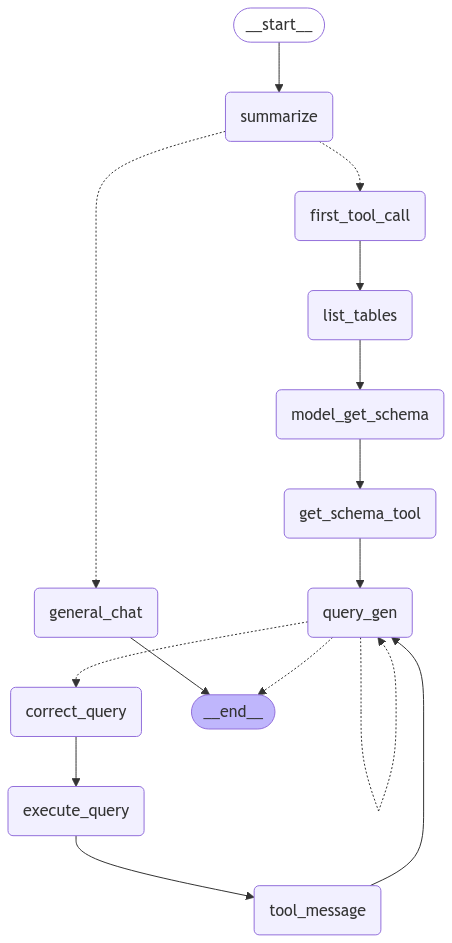

In [320]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [327]:
for event in graph.stream(
    {"messages": [("user", "What are their pay tiers? ")]},config=config
):
    for key,value in event.items():
        if value["messages"]:
            print(value["messages"][-1].pretty_print())

================================ Remove Message ================================


None
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (tool_abcd123)
 Call ID: tool_abcd123
  Args:
None
================================= Tool Message =================================
Name: sql_db_list_tables

employee
None
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_6fy9)
 Call ID: call_6fy9
  Args:
    table_names: employee
None
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE employee (
	`EmployeeID` INTEGER NOT NULL, 
	`EmployeeName` VARCHAR(255) NOT NULL, 
	`DateOfJoining` DATE NOT NULL, 
	`EmployeeType` VARCHAR(255), 
	`PayTier` VARCHAR(255), 
	PRIMARY KEY (`EmployeeID`)
)ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci DEFAULT CHARSET=utf8mb4

/*
3 rows from employee table:
EmployeeID	EmployeeName	DateOf

In [328]:
event

{'query_gen': {'messages': [AIMessage(content='Answer: The pay tiers of the employees are: \n- Mona Young: Tier 3\n- Eve Martin: Tier 1\n- Isabella Clark: Tier 4\n- Chloe White: Tier 2\n- Eleanor Ross: Tier 1', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 865, 'total_tokens': 917, 'completion_time': 0.189090909, 'prompt_time': 0.054171503, 'queue_time': 0.905338187, 'total_time': 0.243262412}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_0a4b7a8df3', 'finish_reason': 'stop', 'logprobs': None}, id='run-646c5d6e-528f-460b-8daa-c4983c945a14-0', usage_metadata={'input_tokens': 865, 'output_tokens': 52, 'total_tokens': 917})]}}

In [329]:
event["query_gen"]["messages"][-1].content

'Answer: The pay tiers of the employees are: \n- Mona Young: Tier 3\n- Eve Martin: Tier 1\n- Isabella Clark: Tier 4\n- Chloe White: Tier 2\n- Eleanor Ross: Tier 1'

In [56]:
snapshot = graph.get_state(config)

In [57]:
{k: v for k, v in snapshot.values.items() if k in "summary"}


{'summary': ['']}

In [58]:
for event in graph.stream(
    {"messages": [("user", "tell my name")]},config=config
):
    for key,value in event.items():
        print(value["messages"][-1].pretty_print())

ValueError: variable summary should be a list of base messages, got [''

* The user requested a list of different categories of employees.
* In response, the user was provided with the schema of the employee table, which included the EmployeeType column.
* To generate the list of different categories of employees, the following SQL query was executed: "SELECT DISTINCT EmployeeType FROM employee".
* The query returned the following result: [('Manager',), ('Engineer-1',), ('Tester',), ('Engineer-2',), ('Team Lead',)].
* Therefore, the different categories of employees are Manager, Engineer-1, Tester, Engineer-2, and Team Lead.
] of type <class 'str'>

## Trying an different architecture